In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf

#load file
df = pd.read_excel("car_insurance_claims.xlsx")
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10302 entries, 0 to 10301
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   ID          10302 non-null  int64         
 1   KIDSDRIV    10302 non-null  int64         
 2   BIRTH       10302 non-null  datetime64[ns]
 3   AGE         10295 non-null  float64       
 4   HOMEKIDS    10302 non-null  int64         
 5   YOJ         9754 non-null   float64       
 6   INCOME      9732 non-null   float64       
 7   PARENT1     10302 non-null  object        
 8   HOME_VAL    9727 non-null   float64       
 9   MSTATUS     10302 non-null  object        
 10  GENDER      10302 non-null  object        
 11  EDUCATION   10302 non-null  object        
 12  OCCUPATION  9637 non-null   object        
 13  TRAVTIME    10302 non-null  int64         
 14  CAR_USE     10302 non-null  object        
 15  BLUEBOOK    10302 non-null  int64         
 16  TIF         10302 non-

In [12]:
# Drop columns
df = df.drop(columns=['ID', 'BIRTH', 'CLAIM_AMT'], errors='ignore')

# Strip leading/trailing spaces from column names
df.columns = df.columns.str.strip()

# Replace missing numeric values with median
num_columns = df.select_dtypes(include=[np.number]).columns
df[num_columns] = df[num_columns].fillna(df[num_columns].median())


# Clean categorical before mapping
df['URBANICITY'] =  df['URBANICITY'].astype(str).str.strip()
df['URBANICITY'] = df['URBANICITY'].str.replace(r'^z', '', regex=True)
df['URBANICITY'] = df['URBANICITY'].replace({
    '1': 'Urban',
    '0':'Rural',
    'nan': 'Urban',
    'Highly Urban/ Urban': 'Urban',
    'Highly Rural/ Rural': 'Rural'
})

df['URBANICITY'] = df['URBANICITY'].fillna('Urban')

df['RED_CAR'] = df['RED_CAR'].astype(str).str.strip().str.replace('z_', '', regex=True).str.capitalize()
df['RED_CAR'] = df['RED_CAR'].replace({'?':'NO', 'Nan':'NO', 'nan':'NO'})
df['RED_CAR'] = df['RED_CAR'].fillna('NO')

df['MSTATUS'] = df['MSTATUS'].astype(str).str.replace('z_', '', regex=True)
df['MSTATUS'] = df['MSTATUS'].replace({'nan':'NO'}).fillna('NO')

df['GENDER'] = df['GENDER'].astype(str).str.strip()
df['GENDER'] = df['GENDER'].replace({'?':'F','nan':'F'}).fillna('F')

# EDUCATION normalization
df['EDUCATION'].unique()
df['EDUCATION'] = df['EDUCATION'].replace({
    'z_High School': 'High School',
    '<High School': 'High School'
})
education_map= {
    'High School': 0,
    'Bachelors': 1,
    'Master': 2,
    'PhD': 3
}
df['EDUCATION'] = df['EDUCATION'].map(education_map)
df['EDUCATION']  = df['EDUCATION'].fillna(0) # fill any remaining missing

# Automatically detect categorical columns
categorical_cols = df.select_dtypes(include=['object','category']).columns
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode().iloc[0])


#=====Binary columns mapping=====
binary_maps = {
    'PARENT1': {'No': 0, 'Yes': 1},
    'MSTATUS': {'No': 0, 'Yes': 1},
    'GENDER': {'F': 0, 'M': 1},
    'CAR_USE': {'Private': 0, 'Commercial': 1},
    'RED_CAR': {'No': 0, 'Yes': 1},
    'REVOKED': {'No': 0, 'Yes': 1},
    'URBANICITY':{'Urban': 1, 'Rural':0}
}

# Apply all binary mappings in one loop
for col, mapping in binary_maps.items():
    df[col] = df[col].map(mapping)



#---One-hot encoding for nominal values---
df = pd.get_dummies(df, columns=['OCCUPATION','CAR_TYPE'], drop_first=True)


In [13]:
#Calculate the mean of claim flag
df["CLAIM_FLAG"].mean()


np.float64(0.2665501844302077)

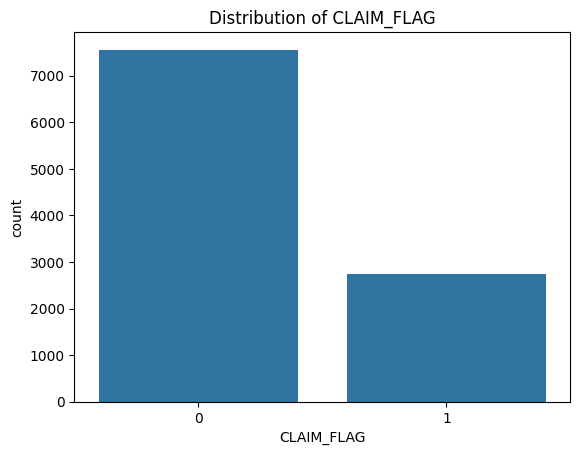

In [14]:
#Visualize the distribution of CLAIM_FLAG
sns.countplot(x='CLAIM_FLAG', data=df)
plt.title('Distribution of CLAIM_FLAG')
plt.show()

In [ ]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix
from imblearn.over_sampling import SMOTE

#define the feature set (X) and the target variable (y)
X = df.drop(columns= ['CLAIM_FLAG']) # CLAIM_FLAG
y = df['CLAIM_FLAG'] #Target variable

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Fill missing values in numerical columns with median
numerical_columns = X_train.select_dtypes(include=['float64', 'int64']).columns
X_train[numerical_columns] = X_train[numerical_columns].fillna(X_train[numerical_columns].median())
X_test[numerical_columns] = X_test[numerical_columns].fillna(X_train[numerical_columns].median())

# Fill missing values in categorical columns with the mode 
categorical_columns = X_train.select_dtypes(include=['object', 'category']).columns

# Fill missing values in X_train
for col in categorical_columns:
   mode_value = X_train[col].mode()
   if not mode_value.empty:
      X_train[col] = X_train[col].fillna(mode_value.iloc[0])
   else:
      # Fallback if mode is empty, fill with 'Unknown'
      X_train[col] = X_train[col].fillna('Unknown')

# Fill missing values in X_test using the mode from the X_train
for col in categorical_columns:
   mode_value = X_train[col].mode()
   if not mode_value.empty:
      X_test[col] = X_test[col].fillna(mode_value.iloc[0])
   else:
      # Fallback if mode is empty, fill with 'Unknown'
      X_test[col] = X_test[col].fillna('Unknown')


# Feature scaling
scaler = StandardScaler()
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])

# Handle class imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Train a logistic regression model
model= LogisticRegression(
   solver='saga',
   class_weight='balanced',
   max_iter=500,
   random_state=42
)
model.fit(X_train_res,y_train_res)

# Make predictions on the test set
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Search for the best threshold
thresholds = np.arange(0.01, 1.0, 0.01)
best_thresh = 0.5   # default threshold
best_f1 = 0     # start with F1=0

# Loop over thresholds to find the best F1-score
for t in thresholds:
   y_pred_temp = (y_prob >=t).astype(int)
   f1 = f1_score(y_test, y_pred_temp)
   if f1 > best_f1:
      best_f1 = f1
      best_thresh = t
print(f"Best Threshold: {best_thresh:.2f}")
print(f"Best F1-score: {best_f1:.4f}")

# make prediction with best threshold
y_pred_best = (y_prob >= best_thresh).astype(int)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("\nclassification Report:\n", classification_report(y_test, y_pred_best))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best))




Best Threshold: 0.48
Best F1-score: 0.5541
Accuracy: 0.70790878214459

classification Report:
               precision    recall  f1-score   support

           0       0.86      0.72      0.78      1506
           1       0.47      0.67      0.55       555

    accuracy                           0.71      2061
   macro avg       0.66      0.70      0.67      2061
weighted avg       0.75      0.71      0.72      2061

ROC-AUC: 0.7532883481090653

Confusion Matrix:
 [[1085  421]
 [ 181  374]]
